<a href="https://colab.research.google.com/github/cfcastillo/DS-6-Notebooks/blob/main/2_Education_Capstone_EDA_and_Processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Definition

The purpose of this project is to identify what factors influence people to choose certain professions or trades. In understanding these factors, we can help colleges like Central New Mexico College (CNM) offer courses that support those professions and better target their marketing to people who are likely to choose those professions.

This project will be a supervised classification problem using tree-based models to identify the factors that will contribute to career choice.



# References

[Oversampling and Undersampling](https://machinelearningmastery.com/combine-oversampling-and-undersampling-for-imbalanced-classification/)

# Data Collection and Cleaning

The data collection and cleaning process is outlined in the notebook titled [1. Education Capstone - Data Collection and Cleaning.ipynb](https://colab.research.google.com/drive/1Y_1b7BmiRF6CSYnoiZqGpfjpbzU4qoFe)


## Column Descriptions

[Here is a summary document showing selected columns.](https://docs.google.com/document/d/1io7TtqebJLtw6FKE7zkbUh26QkG3rEJrZX3Fver9zmU/edit)

# Imports

In [212]:
# grab the imports needed for the project
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn import metrics
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
# from sklearn import tree

# Visualization
import graphviz
from IPython.display import display
from sklearn import tree
sns.set_style('darkgrid')

In [213]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


The team had different data links. The global here is to allow team members to specify who is working on this notebook so that they can run the code in their environment.

In [214]:
# Expected values are: ellie, amy, cecilia - lowercase
team_member = 'cecilia'

# Root drive path
if team_member in ['amy','ellie']:
  root_drive = '/content/drive/MyDrive/'
else: # Cecilia
  root_drive = '/content/drive/MyDrive/Student Folder - Cecilia/Projects/'

# Exploratory Data Analysis (EDA)

Exploratory data analysis, or EDA, is one of the first steps of the data science process and is used to:
1. Understand our data
2. Clean data and prepare it for analysis
3. Generate summary statistics
4. Identify anomalies/outliers
5. Understand our variables and their relationships
6. Help determine what next steps in analysis are appropriate

## Understand Data

We'll first import our clean dataset. To better understand our data we'll look at the general shape and values. Before performing analysis, it's important to understand what our data is as well as what types of variables we are dealing with. 

In [215]:
#Import final data
asec_final = pd.read_csv(root_drive + 'Capstone/Data/FinalData/Trends/asec_2019_trend_v4.csv')
asec_final.shape

(141251, 49)

In [216]:
#Look at the first five rows
asec_final.head()

,Unnamed: 0,DATA_YEAR,GTMETSTA,GEDIV,GESTFIPS,HHINC,H_TENURE,H_LIVQRT,OCCUP,POCCU2,A_MJOCC,A_DTOCC,AGE1,A_SEX,PRDTRACE,PXRACE1,PRCITSHP,A_HGA,PRERELG,A_GRSWK,HRCHECK,HRSWK,PEARNVAL,A_CLSWKR,WEIND,A_MARITL,A_HSCOL,A_WKSTAT,HEA,PEINUSYR,A_AGE,FINC_FR,FINC_SE,FINC_WS,FINC_CSP,FINC_DIS,FINC_DIV,FINC_RNT,FINC_ED,FINC_SS,FINC_SSI,FINC_FIN,FINC_SUR,FINC_INT,FINC_UC,FINC_OI,FINC_VET,FINC_PAW,FINC_WC
0,0,2019,2,1,23,8,1,5,4050,33,3,13,4,1,1,0,1,37,0,0,1,30,18000,1,18,7,0,4,3,0,21,2,2,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
1,1,2019,2,1,23,9,2,1,0,53,0,0,17,2,1,0,1,39,0,0,0,0,0,0,23,4,0,1,3,0,85,2,2,2,2,2,2,2,2,1,2,2,2,2,2,2,2,2,2
2,2,2019,2,1,23,5,2,1,4020,32,3,13,13,2,1,0,1,39,0,0,2,44,12000,1,18,7,0,2,3,0,61,2,2,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
3,3,2019,2,1,23,10,2,1,0,53,0,0,16,2,1,0,1,39,0,0,0,0,0,0,23,5,0,1,5,0,73,2,2,1,2,2,2,2,2,1,1,2,2,2,2,2,2,2,2
4,4,2019,2,1,23,10,2,1,4610,37,3,15,8,1,1,0,1,39,0,0,1,20,12000,1,16,7,0,4,3,0,37,2,2,1,2,2,2,2,2,1,1,2,2,2,2,2,2,2,2


In [217]:
#Get info about each column, including datatype and number of non-null values
asec_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141251 entries, 0 to 141250
Data columns (total 49 columns):
 #   Column      Non-Null Count   Dtype
---  ------      --------------   -----
 0   Unnamed: 0  141251 non-null  int64
 1   DATA_YEAR   141251 non-null  int64
 2   GTMETSTA    141251 non-null  int64
 3   GEDIV       141251 non-null  int64
 4   GESTFIPS    141251 non-null  int64
 5   HHINC       141251 non-null  int64
 6   H_TENURE    141251 non-null  int64
 7   H_LIVQRT    141251 non-null  int64
 8   OCCUP       141251 non-null  int64
 9   POCCU2      141251 non-null  int64
 10  A_MJOCC     141251 non-null  int64
 11  A_DTOCC     141251 non-null  int64
 12  AGE1        141251 non-null  int64
 13  A_SEX       141251 non-null  int64
 14  PRDTRACE    141251 non-null  int64
 15  PXRACE1     141251 non-null  int64
 16  PRCITSHP    141251 non-null  int64
 17  A_HGA       141251 non-null  int64
 18  PRERELG     141251 non-null  int64
 19  A_GRSWK     141251 non-null  int64
 20  HRCH

In [218]:
#See all column names
asec_final.columns

Index(['Unnamed: 0', 'DATA_YEAR', 'GTMETSTA', 'GEDIV', 'GESTFIPS', 'HHINC',
       'H_TENURE', 'H_LIVQRT', 'OCCUP', 'POCCU2', 'A_MJOCC', 'A_DTOCC', 'AGE1',
       'A_SEX', 'PRDTRACE', 'PXRACE1', 'PRCITSHP', 'A_HGA', 'PRERELG',
       'A_GRSWK', 'HRCHECK', 'HRSWK', 'PEARNVAL', 'A_CLSWKR', 'WEIND',
       'A_MARITL', 'A_HSCOL', 'A_WKSTAT', 'HEA', 'PEINUSYR', 'A_AGE',
       'FINC_FR', 'FINC_SE', 'FINC_WS', 'FINC_CSP', 'FINC_DIS', 'FINC_DIV',
       'FINC_RNT', 'FINC_ED', 'FINC_SS', 'FINC_SSI', 'FINC_FIN', 'FINC_SUR',
       'FINC_INT', 'FINC_UC', 'FINC_OI', 'FINC_VET', 'FINC_PAW', 'FINC_WC'],
      dtype='object')

We are particularly interested in the column A_DTOCC, which indicates the detailed occupation codes grouped by industry, because this is the attributed we are interested in modeling. Theremore, some more EDA will be focused on this column.

In [219]:
#See unique values for target column, A_DTOCC
asec_final['A_DTOCC'].unique()

array([13,  0, 15, 16, 19, 22, 12,  2, 17,  6, 10,  1, 21,  8, 20, 18, 14,
        3,  4,  9, 11,  5,  7, 23])

In [220]:
#See frequency for the target column
oc_freq = asec_final['A_DTOCC'].value_counts(ascending=False)
oc_freq

0     52798
1     10239
17     9913
16     8564
8      5638
22     5576
10     5204
13     5124
21     4964
19     4931
2      4236
14     3531
15     3479
20     2693
3      2682
11     2109
9      1773
4      1754
12     1670
6      1586
7      1027
5       881
18      871
23        8
Name: A_DTOCC, dtype: int64

In [221]:
#See percentages for the A_DTOCC column
asec_final['A_DTOCC'].value_counts(ascending=False, normalize=True)

0     0.373789
1     0.072488
17    0.070180
16    0.060630
8     0.039915
22    0.039476
10    0.036842
13    0.036276
21    0.035143
19    0.034909
2     0.029989
14    0.024998
15    0.024630
20    0.019065
3     0.018987
11    0.014931
9     0.012552
4     0.012418
12    0.011823
6     0.011228
7     0.007271
5     0.006237
18    0.006166
23    0.000057
Name: A_DTOCC, dtype: float64

##Clean Data
We will first filter our data to focus in on our features of interest and prepare our data for analysis. 

In [222]:
# filter data to features of interest
keep_cols = ['A_DTOCC','GEDIV','GESTFIPS','HHINC','H_TENURE','A_AGE','A_SEX','PRDTRACE','PRCITSHP','A_HGA','A_GRSWK','HRSWK','PEARNVAL','A_CLSWKR','A_MARITL','HEA','PEINUSYR']
asec_final = asec_final[keep_cols].copy()

We will remove people who have never worked or those who are not in the worker universe (i.e. in military, children)

In [223]:
# drop specified class of worker
wkr = [0,8]
asec_final.drop(asec_final[asec_final.A_CLSWKR.isin(wkr)].index, inplace=True)

###Pre-processing: Balancing Classes

Because we're interested in predicting the occupation code of an individual based on their demographic data, it will be important to ensure all of our classes have equal representation in our training model. As it stands, our classes 1-23 range from a minimum of 8 observations (class 23, Armed Forces) to a maximum of 10239 (class 1, Management Occupations). To balance these classes, we removed those with a low representation, here defined as having 3000 or less observations per class. We then ran the models using both oversampling and undersampling to determine where we achieved better performance. Oversampling performed better so is shown in our final results.

In [224]:
# Balance the data by removing low occupation code counts. Data will then be over and undersampled as part of the modeling process.
threshold = 3000

# drop certain occupational codes falling below specified threshold
df = pd.DataFrame(oc_freq)
occ_to_drop = df[df['A_DTOCC'] < threshold].index
asec_final.drop(asec_final[asec_final['A_DTOCC'].isin(occ_to_drop)].index, inplace=True)

We will also change our continuous variables to x datatypes and our categorical variables to y datatypes

In [225]:
# Get copy of data that can be manipulated for EDA and models so we preserve original data.
asec_eda = asec_final.copy()
asec_models = asec_final.copy()

In [226]:
# continuous variables
cont_var = ['A_AGE', 'A_GRSWK', 'HRSWK', 'PEARNVAL']

# convert df to categorical (since most variables are categorical)
asec_eda = asec_eda.astype('category')

# convert rest of df to integers
asec_eda[cont_var] = asec_eda[cont_var].astype('int')

In [227]:
#filter A_GRSWK and PEARNVAL to only have values >0
asec_eda = asec_eda[asec_eda['A_GRSWK'] > 0]
asec_eda = asec_eda[asec_eda['PEARNVAL'] > 0]

##Summary Statistics
Next we will generate summary statistics to identify anomalies

In [228]:
# summary statistics of categorical variables
asec_eda.describe(include=['category'])

,A_DTOCC,GEDIV,GESTFIPS,HHINC,H_TENURE,A_SEX,PRDTRACE,PRCITSHP,A_HGA,A_CLSWKR,A_MARITL,HEA,PEINUSYR
count,9973,9973,9973,9973,9973,9973,9973,9973,9973,9973,9973,9973,9973
unique,12,9,51,41,3,2,15,5,16,4,7,5,26
top,17,5,6,41,1,2,1,1,39,1,1,2,0
freq,1508,1785,845,4557,6773,5208,8143,8439,2769,8461,5350,3747,8439


In [229]:
# summary statistics of continuous variables
asec_eda.describe(include=[np.number])

,A_AGE,A_GRSWK,HRSWK,PEARNVAL
count,9973.000000,9973.000000,9973.000000,9.973000e+03
mean,42.818610,963.681640,38.961496,5.522132e+04
std,14.649491,703.877298,10.936720,7.190316e+04
min,15.000000,1.000000,1.000000,5.000000e+01
25%,31.000000,480.000000,40.000000,2.300000e+04
50%,42.000000,769.000000,40.000000,4.000000e+04
75%,55.000000,1250.000000,40.000000,6.500000e+04
max,85.000000,2885.000000,99.000000,1.753999e+06


In [230]:
#See frequency for the target column since we removed low count categories
oc_freq = asec_eda['A_DTOCC'].value_counts(ascending=False)
oc_freq

17    1508
1     1394
16    1175
8      911
10     834
21     744
22     735
13     668
2      617
19     573
14     424
15     390
Name: A_DTOCC, dtype: int64

In [231]:
#See percentages for the A_DTOCC column since we removed low count categories
asec_eda['A_DTOCC'].value_counts(ascending=False, normalize=True)

17    0.151208
1     0.139777
16    0.117818
8     0.091347
10    0.083626
21    0.074601
22    0.073699
13    0.066981
2     0.061867
19    0.057455
14    0.042515
15    0.039106
Name: A_DTOCC, dtype: float64

##Outliers
To visualize our continuous variables for outliers and evaluate distribution, we will plot them with histograms and boxplots. 

### Histograms

Text(38.75, 0.5, 'Count')

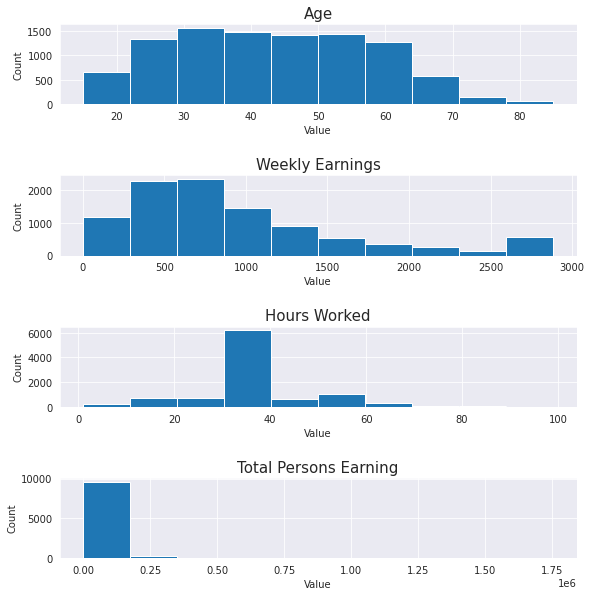

In [232]:
# create df with continuous variables
hist_df = asec_eda[cont_var].copy()

# plot
fig, axs = plt.subplots(4, figsize = (8,8))
fig.tight_layout(h_pad=5, w_pad=5)
axs[0].hist(hist_df['A_AGE'])
axs[0].set_title('Age', loc='center', size=15)
axs[0].set_xlabel('Value')
axs[0].set_ylabel('Count')
axs[1].hist(hist_df['A_GRSWK'])
axs[1].set_title('Weekly Earnings', loc='center', size=15)
axs[1].set_xlabel('Value')
axs[1].set_ylabel('Count')
axs[2].hist(hist_df['HRSWK'])
axs[2].set_title('Hours Worked', loc='center', size=15)
axs[2].set_xlabel('Value')
axs[2].set_ylabel('Count')
axs[3].hist(hist_df['PEARNVAL'])
axs[3].set_title('Total Persons Earning', loc='center', size=15)
axs[3].set_xlabel('Value')
axs[3].set_ylabel('Count')

###Boxplots

Text(0.5, 1.0, 'Total Persons Earning')

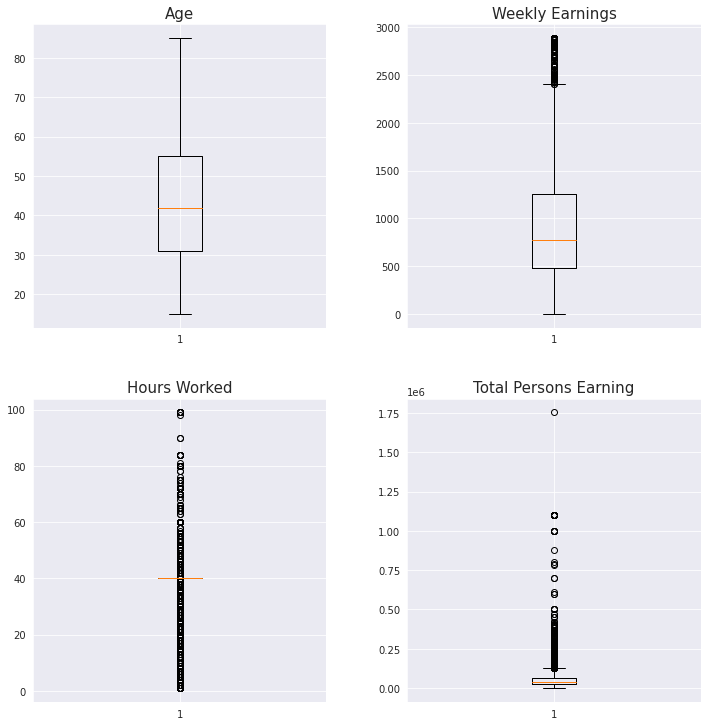

In [233]:
# plot
fig, axs = plt.subplots(2,2, figsize = (10,10))
fig.tight_layout(h_pad=5, w_pad=5)
axs[0,0].boxplot(hist_df['A_AGE'])
axs[0,0].set_title('Age', loc='center', size=15)
axs[0,1].boxplot(hist_df['A_GRSWK'])
axs[0,1].set_title('Weekly Earnings', loc='center', size=15)
axs[1,0].boxplot(hist_df['HRSWK'])
axs[1,0].set_title('Hours Worked', loc='center', size=15)
axs[1,1].boxplot(hist_df['PEARNVAL'])
axs[1,1].set_title('Total Persons Earning', loc='center', size=15)

The hours worked and age variables are fairly normally distributed with no large outliers, while the earnings variables have large upper outliers. However, with the context of wage gaps in the United States, this trend is to be expected, with the majority of individuals earning low - medium wages and a small amount of people earning very large wages at the top.

##Variable Relationships

Next we will visualize our data to better understand our variables and the relationships between them.

###Correlation
Correlation is only appropriate for continuous variables, so we'll create a subset of variables to evaluate using this method. 

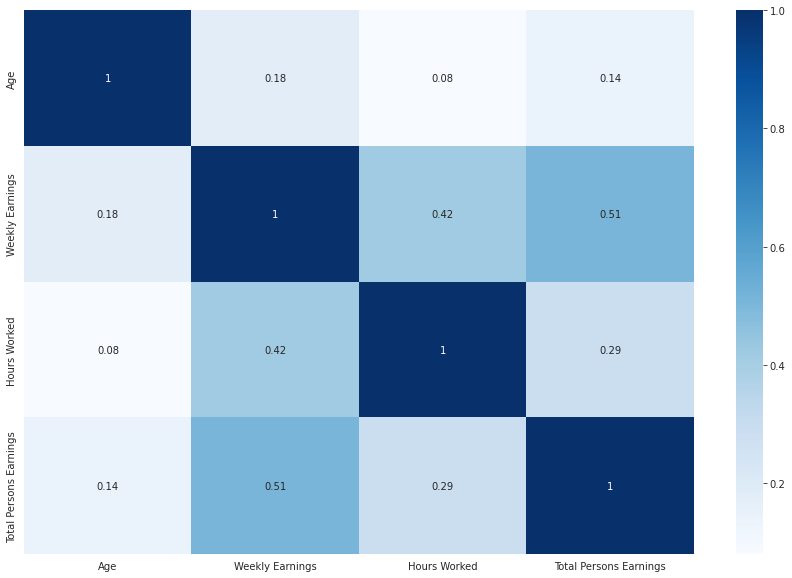

In [234]:
# Correlation plot
plt.figure(figsize=(15,10))
correlation_matrix = hist_df.corr().round(2)
sns.heatmap(data=correlation_matrix, annot=True, cmap='Blues', xticklabels=['Age', 'Weekly Earnings', 'Hours Worked', 'Total Persons Earnings'], 
            yticklabels=['Age', 'Weekly Earnings', 'Hours Worked', 'Total Persons Earnings'])

In [235]:
# Numerically looking at the correlations
corrs = hist_df.corr().round(2).unstack().abs()
corrs = corrs[(corrs < 1) & (corrs > 0.2)]
corrs.sort_values(ascending = False)

PEARNVAL  A_GRSWK     0.51
A_GRSWK   PEARNVAL    0.51
HRSWK     A_GRSWK     0.42
A_GRSWK   HRSWK       0.42
PEARNVAL  HRSWK       0.29
HRSWK     PEARNVAL    0.29
dtype: float64

Regarding continuous variables, hours worked in a week is correlated to the person's total earnings, which is logical. Within this dataset we would anticipate that several variables are correlated with each other and will use methods which are not contingent on uncorrelated predictors. 

##Reflection and Next Steps
Finally, we will reflect on the analysis and determine next steps.

The data are not normally distributed, but do show some interesting trends between our variables of interest. We will utilize models which do not assume normal distributions or uncorrelated variables. 

# Data Processing / Models

Tree based models support our supervised classification problem. 


In [236]:
# Separating data into training and testing sets

# SLIDE: Method for choice - Amy ran them all and then culled them out picking only those with greater than 0.20 feature importance.

keep_cols = ['GEDIV','GESTFIPS','HHINC','H_TENURE',
             'A_AGE', 'A_SEX', 'PRDTRACE', 'PRCITSHP', 'A_HGA', 'A_GRSWK','HRSWK','PEARNVAL', 
             'A_CLSWKR', 'A_MARITL', 'HEA','PEINUSYR']
X = asec_models[keep_cols].copy()
y = asec_models['A_DTOCC'].copy()

In [237]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71399 entries, 0 to 141249
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   GEDIV     71399 non-null  int64
 1   GESTFIPS  71399 non-null  int64
 2   HHINC     71399 non-null  int64
 3   H_TENURE  71399 non-null  int64
 4   A_AGE     71399 non-null  int64
 5   A_SEX     71399 non-null  int64
 6   PRDTRACE  71399 non-null  int64
 7   PRCITSHP  71399 non-null  int64
 8   A_HGA     71399 non-null  int64
 9   A_GRSWK   71399 non-null  int64
 10  HRSWK     71399 non-null  int64
 11  PEARNVAL  71399 non-null  int64
 12  A_CLSWKR  71399 non-null  int64
 13  A_MARITL  71399 non-null  int64
 14  HEA       71399 non-null  int64
 15  PEINUSYR  71399 non-null  int64
dtypes: int64(16)
memory usage: 9.3 MB


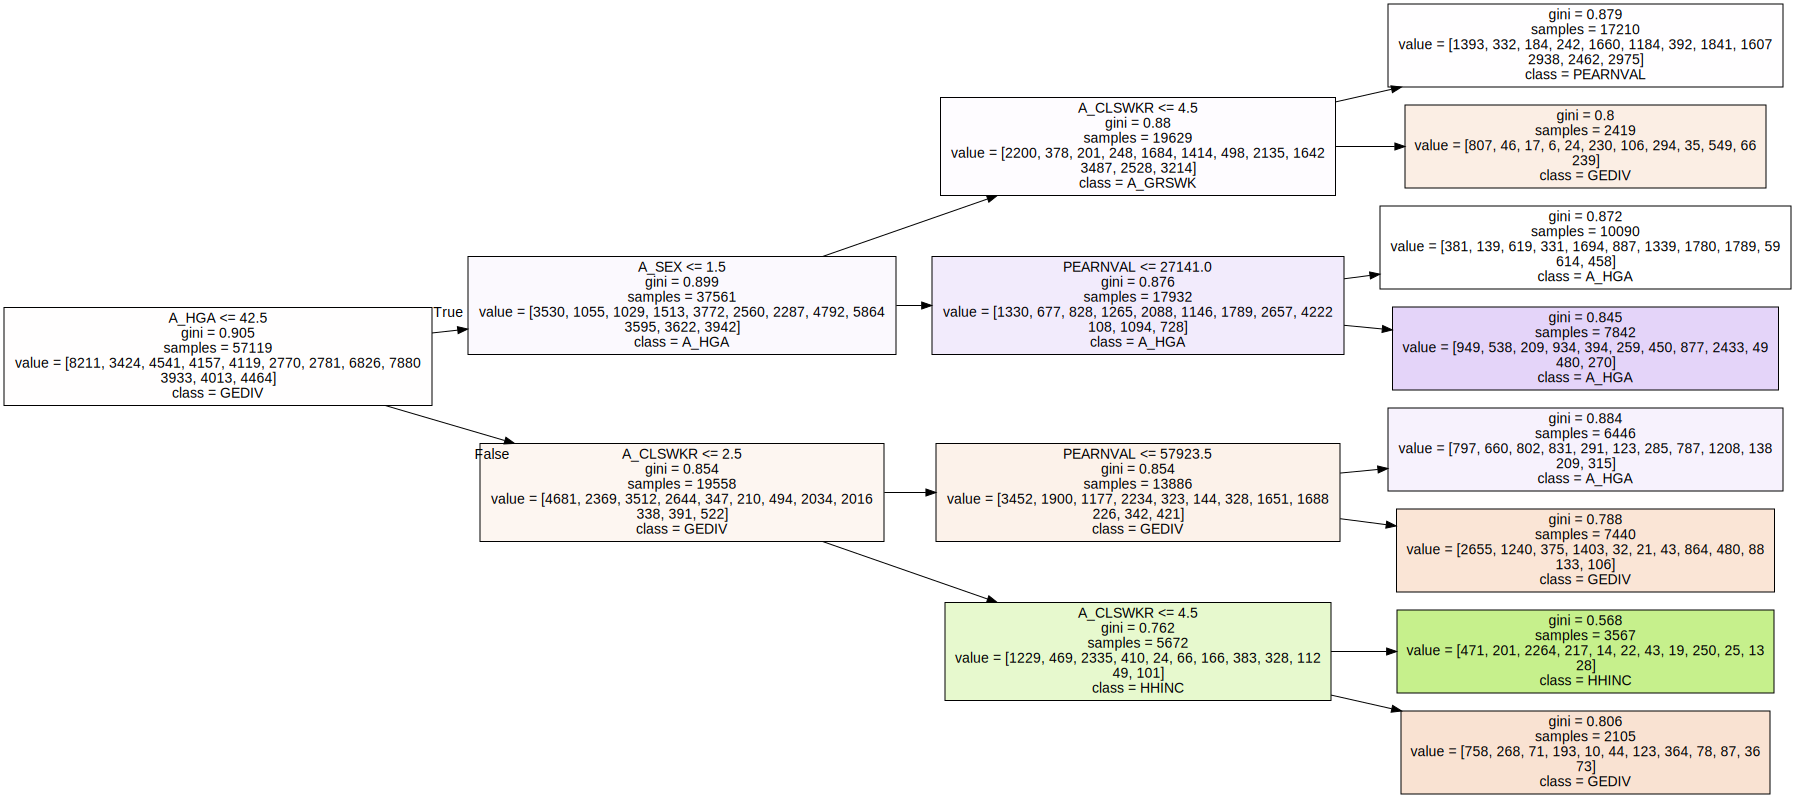

In [238]:
#Basic decision tree for the purpose of visualization
class_names = X.columns.to_list()
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
model = DecisionTreeClassifier(max_depth=3, random_state=0)
model.fit(X_train,y_train)

#TODO: resize DOT image to fit on screen
display(graphviz.Source(tree.export_graphviz(model, feature_names = X.columns, 
                                             class_names=class_names, filled = True, rotate=True)))

## Random Forest - Amy

Ran through model with 50 trees, 10 CV loops for each tree, and default parameters for the RandomTreeClassifier. 
___

RESULTS USING 10 YEAR DATASET
- With the unmodified, oversampled POCCU2 code, we received an accuracy of .14
- With the modified, oversampled POCCU2 code (NEW_POCCU2), we received an accuracy of .22
- With the modified, non-sampled NEW_POCCU2 code, we received an accuracy of .26
- With the non-sampled A_DTOCC code, we received an accuracy of .24
- With the oversampled A_DTOCC code, we received and accuracy of .17
---
RESULTS USING 2019 DATASET
- With the non-sampled A_DTOCC code, we received an accuracy of .26
- With the oversampled A_DTOCC code (with variable columns removed), we received an accuracy of .17
- With the oversampled A_DTOCC code (with only the other occupation columns removed), we received an accuracy of .17
---
REMOVED THE ARGUEMENTS FOR RANDOMFORESTCLASSIFIER TO USE ONLY THE DEFAULT PARAMETERS. 

- With the oversampled A_DTOCC code (with variable columns removed), we received an accuracy of .27
- With the oversampled A_DTOCC code (with only the other occupation columns removed), we received an accuracy of .29
- With the unmodified, oversampled POCCU2 code, we received an accuracy of .27
- With the modified, oversampled POCCU2 code (NEW_POCCU2), we received an accuracy of .32

---
REMOVED VALUES FOR A_DTOCC WHICH WERE UNDER 3,000 (TOTAL VALUE COUNT), LEAVING US WITH 12 OCCUPATION CODES AND JUST OVER 71,000 RECORDS.

- With the oversampled A_DTOCC code (with WEIND included), we received an accuracy of .55
- Without the oversampled A_DTOCC code (with WEIND included), we received an accuracy of .43
- With the oversampled A_DTOCC code (without WEIND included), we received an accuracy of .34
- Without the oversampled A_DTOCC code (without WEIND included), we received an accuracy of .30

In [239]:
# Creating a model and cross validating over it multiple times and using over sampling
cv_loops = 5
ros = RandomOverSampler()
accuracy_cv = np.zeros(cv_loops)

for i in range(cv_loops):
  X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X, y, test_size=0.20)
  X_train_over_rf, y_train_over_rf = ros.fit_resample(X_train_rf, y_train_rf)
  X_train_over_df_rf = pd.DataFrame(X_train_over_rf, columns=X_train_rf.columns, dtype=float)

  # number of trees is 100 by default
  rfModel = RandomForestClassifier()
  rfModel.fit(X_train_over_df_rf, y_train_over_rf)
  y_pred_rf = rfModel.predict(X_test_rf)

  accuracy_cv[i] = accuracy_score(y_pred_rf, y_test_rf)

print('Result:')
print(accuracy_cv.mean().round(2))

Result:
0.34


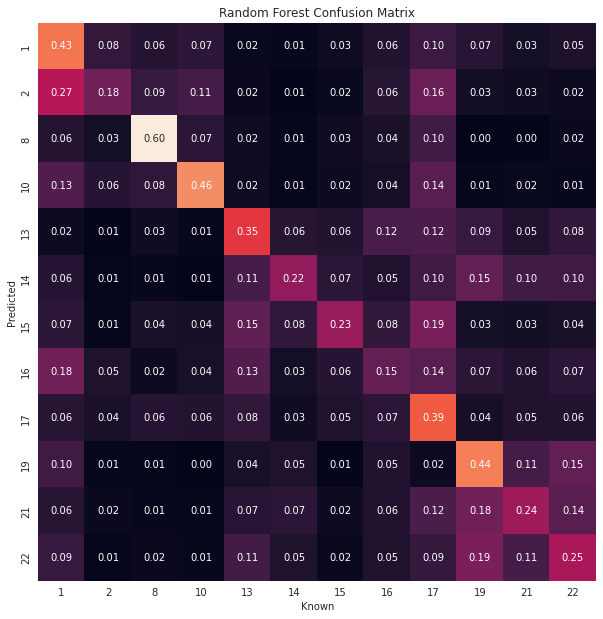

In [240]:
# CM with percentages from first RF model (with over sampling)
classes_rf = y_test_rf.sort_values().unique()
plt.figure(figsize=(10,15))
mat = metrics.confusion_matrix(y_test_rf,y_pred_rf)
cmn = mat.astype('float') / mat.sum(axis=1)[:, np.newaxis]
sns.heatmap(cmn, square=True, annot=True, fmt='.2f', cbar=False,
            xticklabels=classes, yticklabels=classes_rf)
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Known')
plt.ylabel('Predicted');

In [241]:
# Classification report for random forest results.
classes_rf = y_test_rf.sort_values().unique()
labels_rf = list(map(str, classes_rf))
classification_result_rf = classification_report(y_test_rf, y_pred_rf, target_names=labels_rf)
print("Random Forest Classification Report")
print(classification_result_rf)

Random Forest Classification Report
              precision    recall  f1-score   support

           1       0.42      0.43      0.42      2042
           2       0.22      0.18      0.19       794
           8       0.56      0.60      0.58      1155
          10       0.44      0.46      0.45       995
          13       0.29      0.35      0.31      1036
          14       0.25      0.22      0.23       718
          15       0.25      0.23      0.24       715
          16       0.26      0.15      0.19      1724
          17       0.35      0.39      0.37      1941
          19       0.30      0.44      0.36       986
          21       0.26      0.24      0.25      1036
          22       0.25      0.25      0.25      1138

    accuracy                           0.34     14280
   macro avg       0.32      0.33      0.32     14280
weighted avg       0.33      0.34      0.33     14280



Text(0, 0.5, 'Random Forest Feature Importance Score')

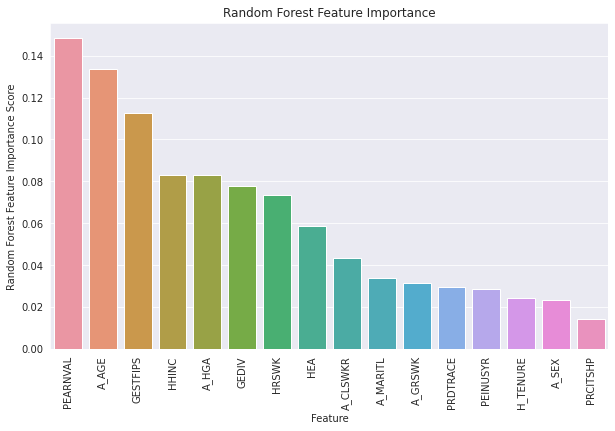

In [242]:
# Determine feature importance for Random Forest optimal results
feat_imp_rf = pd.Series(rfModel.feature_importances_, index=X_train_rf.columns).sort_values(ascending=False)
plt.figure(figsize = (10,6))
ax = sns.barplot(x = feat_imp_rf.index, y = feat_imp_rf.values)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
plt.title('Random Forest Feature Importance')
plt.xlabel('Feature')
plt.ylabel('Random Forest Feature Importance Score')

Important features showing more than 50% importance for Random Forest were consistently:

- PEARNVAL - individual total earnings
- A_AGE - individual age
- GESTFIPS - State in which household resides
- A_HGA - individual education level
- HHINC - household income
- GEDIV - Region in which household resides
- HRSWK - How many hours per week an individual worked
- HEA - A rating of individual health

## XG Boost - Ellie/Cecilia

[XG Boost Documentation](https://xgboost.readthedocs.io/en/stable/tutorials/index.html)

[Grid Search CV documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)

[Class notebook on XG Boost](https://colab.research.google.com/drive/1q1xJOKgVCM-BYfrarCdk4EgE42ZUdVEO)

[Class lecture on XG Boost](https://docs.google.com/presentation/d/1rEi9AKVslEAzyskRPbKWRfGikhcfFfmU/edit#slide=id.p1)

[XG Boost and imbalanced classes](https://towardsdatascience.com/boosting-techniques-in-python-predicting-hotel-cancellations-62b7a76ffa6c)



In [243]:
# Run xgboost with best parameters from hyperparameterized testing
# run oversampler. Note: ran undersampler with hypertuning because tuning timed out with oversampler.
# I realize the results will vary with different data, but in the interest of time, this is how I proceeded.

best_lr=0.3
best_md=6
best_ne=80

values, counts = np.unique(y, return_counts=True)
class_count = len(values)

xgbc = xgb.XGBClassifier(objective ='multi:softmax', verbosity=0, seed = 10,
                         max_depth=best_md, n_estimators=best_ne, learning_rate=best_lr, num_classes=class_count)



# use default parameters
# xgbc = xgb.XGBClassifier(objective='multi:softmax')

X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(X,y,test_size=0.20)
X_train_samp_xgb, y_train_samp_xgb = ros.fit_resample(X_train_xgb, y_train_xgb)
X_train_samp_df_xgb = pd.DataFrame(X_train_samp_xgb, columns=X_train_xgb.columns, dtype=float)

xgbc.fit(X_train_samp_df_xgb,y_train_samp_xgb)
y_pred_xgb = xgbc.predict(X_test_xgb)

print(f'params: lr={best_lr} | md={best_md} | ne={best_ne}')
print(f'training accuracy={xgbc.score(X_train_samp_df_xgb, y_train_samp_xgb)}')
print(f'testing accuracy={xgbc.score(X_test_xgb, y_test_xgb)}')

params: lr=0.3 | md=6 | ne=80
training accuracy=0.5665718291274946
testing accuracy=0.3357142857142857


[XG Boost parameters](https://xgboost.readthedocs.io/en/stable/parameter.html#)

using overfitting plus best params from hyper testing on under sampled data.
---
- increased test data size to .30
- params: lr=0.3 | md=6 | ne=80
- training accuracy=0.588235982401947
- testing accuracy=0.33949579831932775
---
- params: lr=0.1 | md=6 | ne=80
- training accuracy=0.43914908322153107
- testing accuracy=0.3285014005602241
---
- params: lr=0.2 | md=6 | ne=80
- training accuracy=0.5082256885205947
- testing accuracy=0.33431372549019606
---
- params: lr=0.2 | md=5 | ne=80
- training accuracy=0.4451932807124064
- testing accuracy=0.33599439775910367
---
- params: lr=0.2 | md=5 | ne=110
- training accuracy=0.4757396809935468
- testing accuracy=0.33802521008403363
---
- params: lr=0.2 | md=5 | ne=100
- training accuracy=0.46148088910761154
- testing accuracy=0.33060224089635853
---
- params: lr=0.2 | md=5 | ne=90
- training accuracy=0.4571677962620661
- testing accuracy=0.33879551820728293
---
- params: lr=0.3 | md=6 | ne=100
- training accuracy=0.3543076923076923
- testing accuracy=0.32072829131652664
---
- params: lr=0.1 | md=5 | ne=100
- training accuracy=0.40673174700020337
- testing accuracy=0.332703081232493

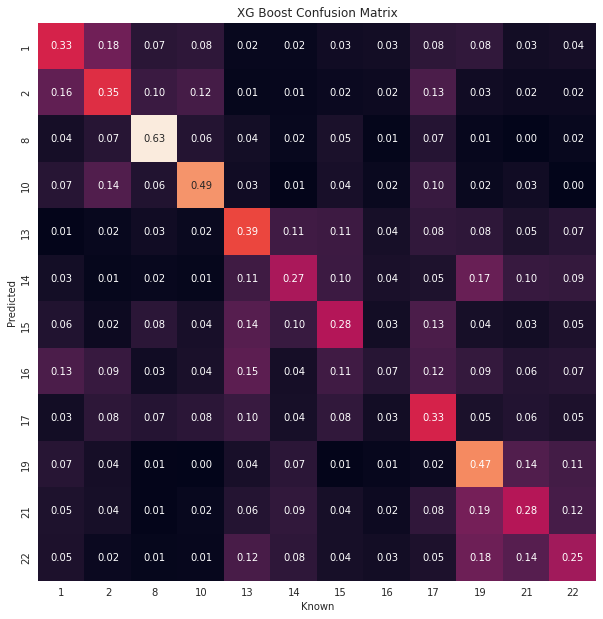

In [244]:
# CM with percentages from XG Boost model (with over sampling)
classes = y_test_xgb.sort_values().unique()
plt.figure(figsize=(10,15))
mat = metrics.confusion_matrix(y_test_xgb,y_pred_xgb)
cmn = mat.astype('float') / mat.sum(axis=1)[:, np.newaxis]
sns.heatmap(cmn, square=True, annot=True, fmt='.2f', cbar=False,
            xticklabels=classes, yticklabels=classes)
plt.title('XG Boost Confusion Matrix')
plt.xlabel('Known')
plt.ylabel('Predicted');

In [245]:
# Classification Report for XG Boost optimal results
labels = list(map(str, classes))
classification_result = classification_report(y_test_xgb, y_pred_xgb, target_names=labels)
print("XG Boost Classification Report")
print(classification_result)

XG Boost Classification Report
              precision    recall  f1-score   support

           1       0.48      0.33      0.39      2155
           2       0.23      0.35      0.28       892
           8       0.53      0.63      0.58      1100
          10       0.43      0.49      0.46      1021
          13       0.28      0.39      0.33       988
          14       0.22      0.27      0.24       691
          15       0.20      0.28      0.23       716
          16       0.24      0.07      0.11      1675
          17       0.40      0.33      0.36      2010
          19       0.30      0.47      0.37       995
          21       0.25      0.28      0.27       948
          22       0.27      0.25      0.26      1089

    accuracy                           0.34     14280
   macro avg       0.32      0.35      0.32     14280
weighted avg       0.34      0.34      0.33     14280



Importance Type can be adjusted to get different scores from tree models:

For tree model Importance type can be defined as:

- ‘weight’: the number of times a feature is used to split the data across all trees.

- ‘gain’: the average gain across all splits the feature is used in.

- ‘cover’: the average coverage across all splits the feature is used in.

- ‘total_gain’: the total gain across all splits the feature is used in.

- ‘total_cover’: the total coverage across all splits the feature is used in.

[XG Boost Documentation on Importance Type](https://xgboost.readthedocs.io/en/latest/python/python_api.html)

[Explanation of each Importance Type in more detail](https://towardsdatascience.com/be-careful-when-interpreting-your-features-importance-in-xgboost-6e16132588e7)

[Feature importance comparison between Random Forest and XG Boost](https://forums.fast.ai/t/feature-importance-of-random-forest-vs-xgboost/17561/2)

Text(0, 0.5, 'XGB Feature Importance Score')

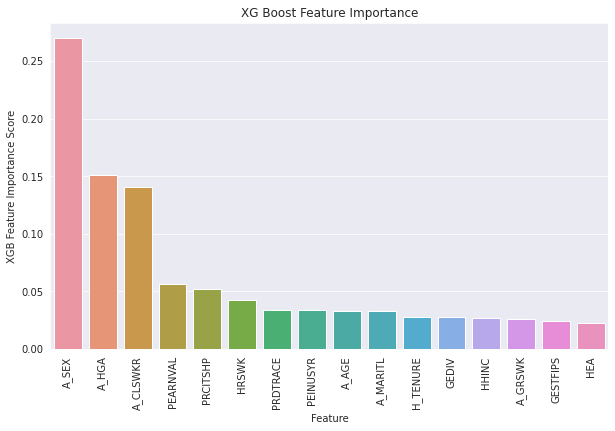

In [246]:
# Determine feature importance for XG Boost optimal results - 
# Experimenting with importance types to see which one most closely matches random forest results
# Note: default that matches feature_importances_ is "gain"
imp_type = ['weight','gain','cover','total_gain','total_cover']
feat_imp_xgb1 = pd.Series(xgbc.get_booster().get_score(importance_type=imp_type[1])).sort_values(ascending=False)
plt.figure(figsize = (10,6))
# Divide by sum to get relative importances to match feature_importances_ results
ax = sns.barplot(x = feat_imp_xgb1.index, y = feat_imp_xgb1.values/feat_imp_xgb1.sum())
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
plt.title('XG Boost Feature Importance')
plt.xlabel('Feature')
plt.ylabel('XGB Feature Importance Score')

Text(0, 0.5, 'XGB Feature Importance Score')

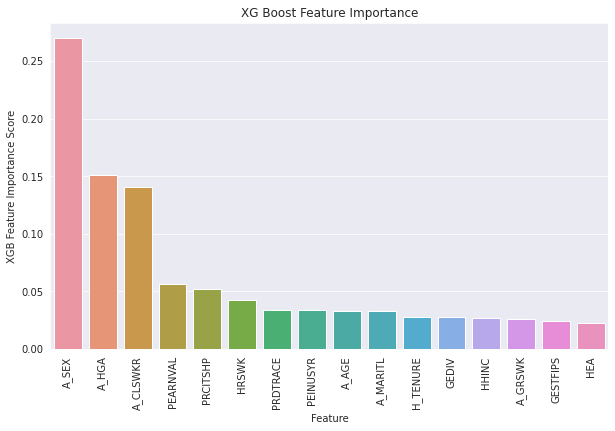

In [247]:
# Determine feature importance for XG Boost optimal results
# Using XG Boost methodology - produces significantly different results from Random Forest
feat_imp_xgb2 = pd.Series(xgbc.feature_importances_, index=X_train_xgb.columns).sort_values(ascending=False)
plt.figure(figsize = (10,6))
ax = sns.barplot(x = feat_imp_xgb2.index, y = feat_imp_xgb2.values)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
plt.title('XG Boost Feature Importance')
plt.xlabel('Feature')
plt.ylabel('XGB Feature Importance Score')

# Comparing Model Outcomes

**Results** 

Random Forest slightly outperformed XG Boost.

- Random Forest - 34%
- XG Boost - 33%

**Choosing Predictors**

For both models, we tried many different predictor variable combinations. Fewer predictors resulted in reduced performance around 18%. Highly correlated predictors such as WEIND (industry) caused overfitting in the model resulting in around 50% performance so it was removed. Several binary classification variables indicating income source did not affect model performance so were removed. To determine the best set of variables, we initially ran them all through the Random Forest model, reviewed feature importance, and selected the variables that contributed 20% or better to the outcome.

**Sampling**

To address the unbalanced nature of our target A_DTOCC - Detailed Occupation Code, we ran both models using a Random Over Sampler, Random Under Sampler and unsampled data. The unsampled data continued to outperform the sampled data. To more accurately balance the data, we removed classes with low volumes (less than 3000 occurances) and then re-tested the data using both the oversampler and undersampler. The oversampler performed better so we used over sampled data for our final model training.

**Training Methodology**

Random Forest was trained with 100 trees and max depth automatically determined by the model using oversampled data to achieve 34% accuracy.,

XG Boost was trained with several different hyperameters

- learning rate - 0.1, 0.2, 0.3
- max depth - 4, 5, 6, 7
- n estimators (number of trees) - 80, 90, 100, 110

In every case, training outperformed testing and validation by around 5%. Adding more trees and increasing max depth increased the disparity between training and testing results due to increased overfitting. Regardless of which hyperparameters were used, validation accuracy was consistently around 33%.

**Classification Report**

Accuracy = (TP+TN)/(TP+FP+FN+TN)

Precision = TP/(TP+FP) - what percentage were truly positive?

Recall = TP/(TP+FN) - which ones were accurately classified?

For both models, classes 8 and 10 had high precision and recall. Secondarily, classes 1, 13, 17 and 19 had at least 40% precision or recall. Here are occupation codes in descending order of frequency

- *1 Management occupations 0010-0430*
- *17 Office and administrative support occupations 5000-5940*
- 16 Sales and related occupations 4700-4965
- **8 Education, training, and library occupations 2200-2550**
- 22 Transportation and material moving occupations 9000-9750
- **10 Healthcare practitioner and technical occupations 3000-3540**
- *13 Food preparation and serving related occupations 4000-4160*
- 21 Production occupations 7700-8965
- *19 Construction and extraction occupations 6200-6940*
- 2 Business and financial operations occupations 0500-0950
- 14 Building and grounds cleaning and maintenance occups. 4200-4250
- 15 Personal care and service occupations 4300-4650

**Feature Importance Discrepancies**

Feature importance differed considerably between the two models. Random Forest important features were

- Primary importance - Age, State, Personal earnings
- Secondary importance - Geo Division, Household income, Education Level, Hours worked per week, Personal health.
- Low importance - all other predictors.

XG Boost important features were

- Primary importance - Sex, Education Level, Worker classification.
- Low importance - all other predictors.

[Below quotes taken from this site:](https://forums.fast.ai/t/feature-importance-of-random-forest-vs-xgboost/17561/2)

Feature importance for Random Forest is calculated as:

```It is sometimes called “gini importance” or “mean decrease impurity” and is defined as the total decrease in node impurity (weighted by the probability of reaching that node (which is approximated by the proportion of samples reaching that node)) averaged over all trees of the ensemble.```

Feature importance for XG Boost is calculated as:

```How the importance is calculated: either “weight”, “gain”, or “cover”. “weight” is the number of times a feature appears in a tree. “gain” is the average gain of splits which use the feature. “cover” is the average coverage of splits which use the feature where coverage is defined as the number of samples affected by the split.```




## Comparison Plots

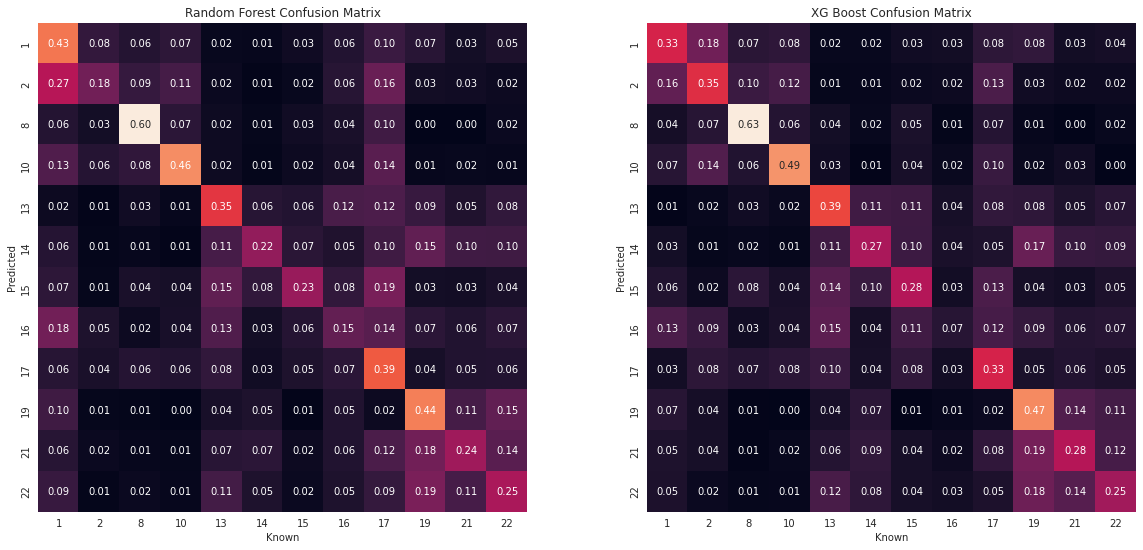

In [248]:
# Show Confusion Matrices side by side
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (20,9))

# Random Forest
classes_rf = y_test_rf.sort_values().unique()
mat = metrics.confusion_matrix(y_test_rf,y_pred_rf)
cmn = mat.astype('float') / mat.sum(axis=1)[:, np.newaxis]
plt_rf_cm = sns.heatmap(cmn, square=True, annot=True, fmt='.2f', cbar=False,
            xticklabels=classes_rf, yticklabels=classes_rf, ax=ax1)
plt_rf_cm.set_title('Random Forest Confusion Matrix')
plt_rf_cm.set_xlabel('Known')
plt_rf_cm.set_ylabel('Predicted');

# XG Boost
classes_xgb = y_test_xgb.sort_values().unique()
mat = metrics.confusion_matrix(y_test_xgb,y_pred_xgb)
cmn = mat.astype('float') / mat.sum(axis=1)[:, np.newaxis]
plt_xgb_cm = sns.heatmap(cmn, square=True, annot=True, fmt='.2f', cbar=False,
            xticklabels=classes_xgb, yticklabels=classes_xgb, ax=ax2)
plt_xgb_cm.set_title('XG Boost Confusion Matrix')
plt_xgb_cm.set_xlabel('Known')
plt_xgb_cm.set_ylabel('Predicted');

In [249]:
# Show Classification Reports together
# Show in different colors
BOLD = '\033[1m'
DARKCYAN = '\033[36m'
PURPLE = '\033[35m'
print(DARKCYAN + BOLD)

classes_rf = y_test_rf.sort_values().unique()
labels = list(map(str, classes_rf))
classification_result_rf = classification_report(y_test_rf, y_pred_rf, target_names=labels)
print("Random Forest Classification Report")
print(classification_result_rf)

print(PURPLE + '\n')

classes_xgb = y_test_xgb.sort_values().unique()
labels = list(map(str, classes_xgb))
classification_result_xgb = classification_report(y_test_xgb, y_pred_xgb, target_names=labels)
print("XG Boost Classification Report")
print(classification_result_xgb)


Random Forest Classification Report
              precision    recall  f1-score   support

           1       0.42      0.43      0.42      2042
           2       0.22      0.18      0.19       794
           8       0.56      0.60      0.58      1155
          10       0.44      0.46      0.45       995
          13       0.29      0.35      0.31      1036
          14       0.25      0.22      0.23       718
          15       0.25      0.23      0.24       715
          16       0.26      0.15      0.19      1724
          17       0.35      0.39      0.37      1941
          19       0.30      0.44      0.36       986
          21       0.26      0.24      0.25      1036
          22       0.25      0.25      0.25      1138

    accuracy                           0.34     14280
   macro avg       0.32      0.33      0.32     14280
weighted avg       0.33      0.34      0.33     14280



XG Boost Classification Report
              precision    recall  f1-score   support

        

Text(0, 0.5, 'XGB Feature Importance Score')

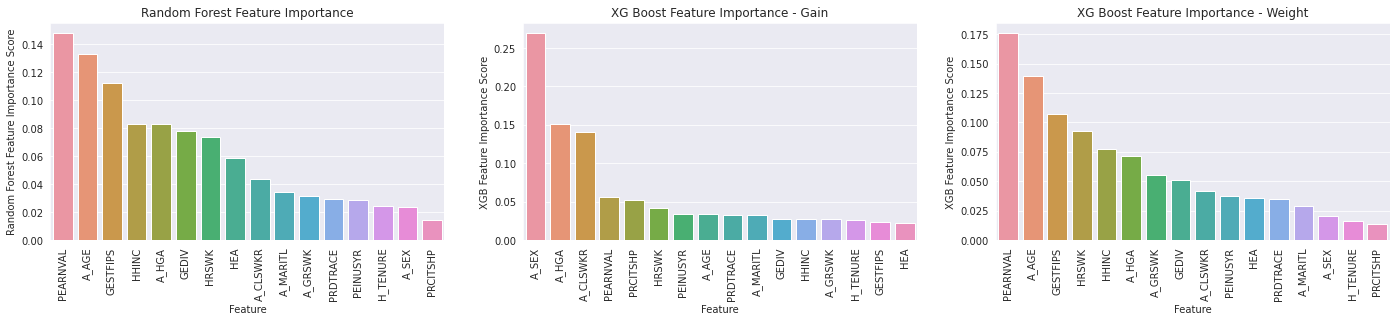

In [250]:
# Show Feature importance side by side
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (24,4))

# Random Forest
feat_imp_rf = pd.Series(rfModel.feature_importances_, index=X_train_rf.columns).sort_values(ascending=False)
plt_rf_f = sns.barplot(x = feat_imp_rf.index, y = feat_imp_rf.values, ax=ax1)
plt_rf_f.set_xticklabels(plt_rf_f.get_xticklabels(),rotation = 90)
plt_rf_f.set_title('Random Forest Feature Importance')
plt_rf_f.set_xlabel('Feature')
plt_rf_f.set_ylabel('Random Forest Feature Importance Score')

# XG Boost - default feature importance calculation
feat_imp_xgb2 = pd.Series(xgbc.feature_importances_, index=X_train_xgb.columns).sort_values(ascending=False)
plt_xgb_f2 = sns.barplot(x = feat_imp_xgb2.index, y = feat_imp_xgb2.values, ax=ax2)
plt_xgb_f2.set_xticklabels(plt_xgb_f.get_xticklabels(),rotation = 90)
plt_xgb_f2.set_title('XG Boost Feature Importance - Gain')
plt_xgb_f2.set_xlabel('Feature')
plt_xgb_f2.set_ylabel('XGB Feature Importance Score')

# XG Boost - total gain importance calculation
# weight is closest to RF Feature Importances
# gain is default XGB feature importances
imp_type = ['weight','gain','cover','total_gain','total_cover']
feat_imp_xgb1 = pd.Series(xgbc.get_booster().get_score(importance_type=imp_type[0])).sort_values(ascending=False)
plt_xgb_f1 = sns.barplot(x = feat_imp_xgb1.index, y = feat_imp_xgb1/feat_imp_xgb1.sum(), ax= ax3)
plt_xgb_f1.set_xticklabels(plt_xgb_f1.get_xticklabels(),rotation = 90)
plt_xgb_f1.set_title('XG Boost Feature Importance - Weight')
plt_xgb_f1.set_xlabel('Feature')
plt_xgb_f1.set_ylabel('XGB Feature Importance Score')